# Churn Prediction

## 0 Libraries

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import arange
from pandas import read_table, set_option
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score, make_scorer, r2_score, mean_squared_error, euclidean_distances

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


## 1 Data Loading and Preparation

In [43]:
orders_agg = pd.read_excel('orders_summary.xlsx')

In [44]:
orders_agg = orders_agg.drop(columns=['transaction_id','name','phone','loyalty_id'])

## 2 Time Window Setup

In [ ]:
observation_dates = [
    '2024-12-31',  # Observation 1
    '2025-01-31',  # Observation 2
    '2025-02-28',  # Observation 3
    '2025-03-31',  # Observation 4
    '2025-04-30',  # Observation 5
    '2025-05-31',  # Observation 6
    '2025-06-30',  # Observation 7
    '2025-07-31',  # Observation 8
]


In [46]:
CHURN_WINDOW = 60

### 2.1 One Snapshot-based Dataset Preparation and Feature Engineering

In [47]:
def create_churn_dataset(df, observation_date, churn_window=60):
    """
    Create features and churn flag for a specific observation date
    """
    observation_date = pd.to_datetime(observation_date)
    churn_period_end = observation_date + pd.Timedelta(days=churn_window)
    
    print(f"\nCreating dataset for: {observation_date.date()}")
    print(f"  Features from transactions up to: {observation_date.date()}")
    print(f"  Churn window: {(observation_date + pd.Timedelta(days=1)).date()} to {churn_period_end.date()}")
    
    # Filter historical data
    historical_data = df[df['transaction_date'] <= observation_date].copy()
    
    if len(historical_data) == 0:
        print(f"  WARNING: No data before {observation_date.date()}")
        return pd.DataFrame()
    
    # ===================================================================
    # Create aggregated features
    # ===================================================================
    
    # RFM and transaction features
    rfm_features = historical_data.groupby('email').agg(
        recency_days=('transaction_date', lambda x: (observation_date - x.max()).days),
        frequency=('transaction_date', 'count'),
        first_transaction_date=('transaction_date', 'min'),
        
        total_spend=('total_bill_amount', 'sum'),
        avg_transaction_value=('total_bill_amount', 'mean'),
        max_transaction_value=('total_bill_amount', 'max'),
        min_transaction_value=('total_bill_amount', 'min'),
        std_transaction_value=('total_bill_amount', 'std'),
        
        total_items_purchased=('quantity', 'sum'),
        avg_items_per_transaction=('quantity', 'mean'),
        max_items_per_transaction=('quantity', 'max'),
        
        total_time_spent=('time_spent_min', 'sum'),
        avg_time_spent=('time_spent_min', 'mean'),
        max_time_spent=('time_spent_min', 'max'),
        min_time_spent=('time_spent_min', 'min'),
        
        total_points_earned=('points_earned', 'sum'),
        avg_points_per_transaction=('points_earned', 'mean')
    ).reset_index()
    
    # Customer attributes (demographics, loyalty)
    customer_attributes = historical_data.groupby('email').agg(
        loyalty_enrolled=('loyalty_enrolled', 'last'),
        tier=('tier', 'last'),
        gender=('gender', 'last'),
        age=('age', 'last'),
        occupation=('occupation', 'last')
    ).reset_index()
    
    # Merge
    features = rfm_features.merge(customer_attributes, on='email', how='left')
    
    # ===================================================================
    # Create derived features
    # ===================================================================
    
    # Tenure and frequency metrics
    features['tenure_days'] = (observation_date - features['first_transaction_date']).dt.days
    features['purchase_frequency_per_month'] = features['frequency'] / (features['tenure_days'] / 30 + 1)
    features['avg_days_between_purchases'] = features['tenure_days'] / (features['frequency'] + 1)
    
    # Spending patterns
    features['spending_per_day'] = features['total_spend'] / (features['tenure_days'] + 1)
    features['spending_per_visit'] = features['total_spend'] / features['frequency']
    
    # Recency ratios
    features['recency_to_tenure_ratio'] = features['recency_days'] / (features['tenure_days'] + 1)
    
    # Time spent patterns
    features['time_per_dollar_spent'] = features['total_time_spent'] / (features['total_spend'] + 1)
    features['time_spent_trend'] = features['avg_time_spent'] / (features['max_time_spent'] + 1)
    
    # Loyalty engagement
    features['points_per_dollar'] = features['total_points_earned'] / (features['total_spend'] + 1)
    features['avg_items_per_dollar'] = features['total_items_purchased'] / (features['total_spend'] + 1)
    
    # Handle NaN values
    features['std_transaction_value'] = features['std_transaction_value'].fillna(0)
    
    # ===================================================================
    # Create churn flag
    # ===================================================================
    future_data = df[(df['transaction_date'] > observation_date) & 
                     (df['transaction_date'] <= churn_period_end)]
    
    active_customers = set(future_data['email'].unique())
    features['churned'] = (~features['email'].isin(active_customers)).astype(int)
    features['observation_date'] = observation_date
    
    # ===================================================================
    # Summary
    # ===================================================================
    print(f"  Total customers: {len(features)}")
    print(f"  Churned: {features['churned'].sum()} ({features['churned'].mean():.1%})")
    print(f"  Retained: {(~features['churned'].astype(bool)).sum()} ({(1-features['churned'].mean()):.1%})")
    
    if 'loyalty_enrolled' in features.columns:
        print(f"  Loyalty enrolled: {features['loyalty_enrolled'].value_counts().to_dict()}")
    
    if 'tier' in features.columns:
        tier_counts = features['tier'].value_counts()
        if len(tier_counts) > 0:
            print(f"  Tier distribution: {tier_counts.to_dict()}")
    
    return features

### 2.2 All Snapshots Combination

In [48]:
all_datasets = []
for obs_date in observation_dates:
    dataset = create_churn_dataset(orders_agg, obs_date, churn_window=CHURN_WINDOW)
    if len(dataset) > 0:
        all_datasets.append(dataset)

# Combine all datasets
combined_data = pd.concat(all_datasets, ignore_index=True)


Creating dataset for: 2024-12-31
  Features from transactions up to: 2024-12-31
  Churn window: 2025-01-01 to 2025-03-01
  Total customers: 413
  Churned: 132 (32.0%)
  Retained: 281 (68.0%)
  Loyalty enrolled: {'Y': 259, 'N': 154}
  Tier distribution: {'Frequent': 144, 'Very Frequent': 115}

Creating dataset for: 2025-01-31
  Features from transactions up to: 2025-01-31
  Churn window: 2025-02-01 to 2025-04-01
  Total customers: 447
  Churned: 131 (29.3%)
  Retained: 316 (70.7%)
  Loyalty enrolled: {'Y': 277, 'N': 170}
  Tier distribution: {'Frequent': 157, 'Very Frequent': 119, 'Casual': 1}

Creating dataset for: 2025-02-28
  Features from transactions up to: 2025-02-28
  Churn window: 2025-03-01 to 2025-04-29
  Total customers: 467
  Churned: 113 (24.2%)
  Retained: 354 (75.8%)
  Loyalty enrolled: {'Y': 290, 'N': 177}
  Tier distribution: {'Frequent': 166, 'Very Frequent': 122, 'Casual': 2}

Creating dataset for: 2025-03-31
  Features from transactions up to: 2025-03-31
  Churn win

In [49]:
all_datasets[0]

,email,recency_days,frequency,first_transaction_date,total_spend,avg_transaction_value,max_transaction_value,min_transaction_value,std_transaction_value,total_items_purchased,...,avg_days_between_purchases,spending_per_day,spending_per_visit,recency_to_tenure_ratio,time_per_dollar_spent,time_spent_trend,points_per_dollar,avg_items_per_dollar,churned,observation_date
0,abigail.chow473@gmail.com,9,1,2024-12-22,65.74,65.740000,65.74,65.74,0.000000,6,...,4.500000,6.574000,65.740000,0.900000,2.217561,0.993289,70.916991,0.089901,0,2024-12-31
1,abigail.johnson162@yahoo.com,10,3,2024-11-11,267.64,89.213333,164.90,19.98,72.675207,21,...,12.500000,5.247843,89.213333,0.196078,1.146516,0.814815,121.232877,0.078172,1,2024-12-31
2,abigail.nguyen35@yahoo.com,16,1,2024-12-15,129.91,129.910000,129.91,129.91,0.000000,11,...,8.000000,7.641765,129.910000,0.941176,0.954854,0.992063,45.710794,0.084027,0,2024-12-31
3,abigail.nowak26@outlook.com,1,2,2024-10-30,96.50,48.250000,50.53,45.97,3.224407,12,...,20.666667,1.531746,48.250000,0.015873,2.533333,0.980159,126.379487,0.123077,0,2024-12-31
4,abigail.singh287@yahoo.com,53,1,2024-11-08,92.94,92.940000,92.94,92.94,0.000000,7,...,26.500000,1.721111,92.940000,0.981481,0.340643,0.969697,71.630828,0.074516,1,2024-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,zoey.kowalski247@icloud.com,5,4,2024-11-10,237.16,59.290000,132.72,4.99,55.570296,17,...,10.200000,4.560769,59.290000,0.096154,1.519987,0.615646,85.606315,0.071381,1,2024-12-31
409,zoey.nguyen372@outlook.com,2,2,2024-10-28,166.66,83.330000,90.43,76.23,10.040916,17,...,21.333333,2.564000,83.330000,0.030769,1.043779,0.921053,81.343195,0.101396,0,2024-12-31
410,zoey.roy215@gmail.com,2,1,2024-12-29,130.44,130.440000,130.44,130.44,0.000000,9,...,1.000000,43.480000,130.440000,0.666667,0.806452,0.990654,0.000000,0.068472,1,2024-12-31
411,zoey.su268@hotmail.com,32,4,2024-10-28,337.75,84.437500,160.41,4.99,63.626498,28,...,12.800000,5.196154,84.437500,0.492308,0.994834,0.825980,64.413284,0.082657,0,2024-12-31


## 3 Data Preparation

### 3.1 Train-Val-Test Splitting

In [50]:
train_dates = observation_dates[:6]  
val_date = observation_dates[6]       
test_date = observation_dates[7]      

# Create splits
train_data = combined_data[combined_data['observation_date'].isin(train_dates)].copy()
val_data = combined_data[combined_data['observation_date'] == val_date].copy()
test_data = combined_data[combined_data['observation_date'] == test_date].copy()

# CRITICAL: Sort training data by observation_date for TimeSeriesSplit
train_data = train_data.sort_values('observation_date').reset_index(drop=True)

C:\Users\kyrie\AppData\Local\Temp\ipykernel_4000\1756402905.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_data = combined_data[combined_data['observation_date'].isin(train_dates)].copy()


### 3.2 Features and Target Splitting

In [51]:
# Separate features and target
train_data = train_data.dropna()
X_train = train_data.drop(columns=['email', 'first_transaction_date','observation_date','churned'])
y_train = train_data['churned']

In [52]:
test_data = test_data.dropna()
X_test = test_data.drop(columns=['email', 'observation_date', 'churned', 'first_transaction_date'])
y_test = test_data['churned']

In [53]:
categorical_cols = ['loyalty_enrolled', 'tier', 'gender', 'occupation']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

### 3.3 StandardScaler and OneHotEncoder Preprocessing

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ])

## 4 Modeling and Tuning

### 4.1 KNN

In [55]:
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [56]:
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'classifier__weights': ['uniform', 'distance']
}

In [57]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [58]:
knn_grid = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [59]:
knn_grid.fit(X_train,y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['recency_days',
                                                                          'frequency',
                                                                          'total_spend',
                                                                          'avg_transaction_value',
                                                                          'max_transaction_value',
                                                                          'min_transaction_value',
                                                                          'std_transaction_value',
                                                                          'total_items_purchased',
                                                                          'avg_...
                                                                          'points_per_dollar',
                                                                          'avg_items_per_dollar']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['loyalty_enrolled',
                                                                          'tier',
                                                                          'gender',
                                                                          'occupation'])])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 20],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=2)

In [60]:
best_knn_pipe = knn_grid.best_estimator_
best_knn_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['recency_days', 'frequency',
                                                   'total_spend',
                                                   'avg_transaction_value',
                                                   'max_transaction_value',
                                                   'min_transaction_value',
                                                   'std_transaction_value',
                                                   'total_items_purchased',
                                                   'avg_items_per_transaction',
                                                   'max_items_per_transaction',
                                                   'total_time_spent',
                                                   'avg_time_spent',
                                                   'max_tim...
                                                   'spending_per_day',
                                                   'spending_per_visit',
                                                   'recency_to_tenure_ratio',
                                                   'time_per_dollar_spent',
                                                   'time_spent_trend',
                                                   'points_per_dollar',
                                                   'avg_items_per_dollar']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['loyalty_enrolled', 'tier',
                                                   'gender', 'occupation'])])),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [61]:
agg_results = {}

In [62]:
knn_pred_test = knn_grid.predict(X_test)

agg_results['KNN'] = accuracy_score(y_test, knn_pred_test)

agg_results['KNN']

0.737012987012987

### 4.2 Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',  # For inbalanced data
        n_estimators=100,
        random_state=42
    ))
])

In [64]:
rf_param_grid = {
    'classifier__max_features': [None, 'sqrt', 'log2'],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [2, 4]
}

In [65]:
rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=2
)

In [66]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['recency_days',
                                                                          'frequency',
                                                                          'total_spend',
                                                                          'avg_transaction_value',
                                                                          'max_transaction_value',
                                                                          'min_transaction_value',
                                                                          'std_transaction_value',
                                                                          'total_items_purchased',
                                                                          'avg_...
                                                                          'occupation'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, 30],
                         'classifier__max_features': [None, 'sqrt', 'log2'],
                         'classifier__min_samples_leaf': [2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=2)

In [67]:
rf_pred_test = rf_grid.predict(X_test)

agg_results['Random Forest'] = accuracy_score(y_test, rf_pred_test)

agg_results['Random Forest']

0.8181818181818182

C:\Users\kyrie\AppData\Local\Temp\ipykernel_4000\3053355370.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fi.head(10).sort_values('importance', ascending=True), palette='viridis')


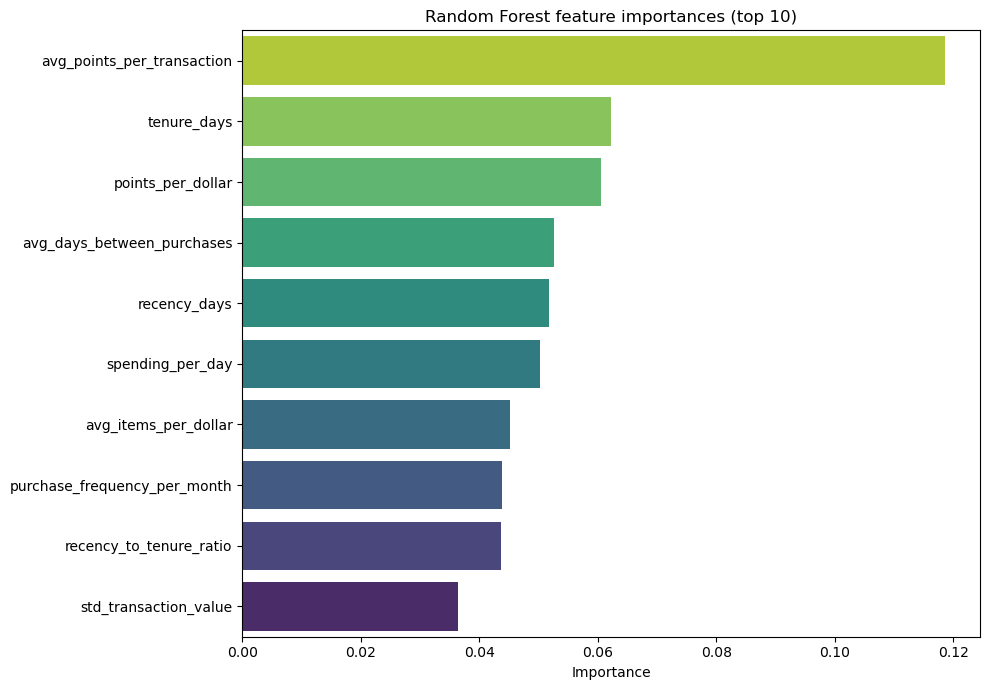

In [ ]:
fi = pd.DataFrame({
    'feature': np.concatenate([
        np.array(numerical_cols),
        rf_grid.best_estimator_.named_steps['preprocessor']
               .named_transformers_['cat']
               .get_feature_names_out(categorical_cols)
    ]),
    'importance': rf_grid.best_estimator_.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, max(6, len(fi.head(20)) * 0.35)))
sns.barplot(x='importance', y='feature', data=fi.head(10).sort_values('importance', ascending=True), palette='viridis')
plt.gca().invert_yaxis()  # ensure most important is shown at the top
plt.title('Random Forest feature importances (top 10)')
plt.xlabel('Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [116]:
print(fi.head(20))

                         feature  importance
15    avg_points_per_transaction    0.118582
17                   tenure_days    0.062197
25             points_per_dollar    0.060572
19    avg_days_between_purchases    0.052547
0                   recency_days    0.051728
20              spending_per_day    0.050190
26          avg_items_per_dollar    0.045141
18  purchase_frequency_per_month    0.043779
22       recency_to_tenure_ratio    0.043632
6          std_transaction_value    0.036403
5          min_transaction_value    0.034549
24              time_spent_trend    0.034099
16                           age    0.033282
11                avg_time_spent    0.033017
14           total_points_earned    0.029758
13                min_time_spent    0.029221
23         time_per_dollar_spent    0.028483
10              total_time_spent    0.025797
12                max_time_spent    0.025020
4          max_transaction_value    0.022779


### 4.3 XGBoost

In [82]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Scale pos weight (for class balance): {scale_pos_weight:.2f}")

Scale pos weight (for class balance): 3.02


In [83]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    ))
])

In [84]:
xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.15],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__scale_pos_weight': [scale_pos_weight],  # Handle imbalance in churn!
    'classifier__min_child_weight': [1, 3, 5]
}

In [85]:
xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [86]:
xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['recency_days',
                                                                          'frequency',
                                                                          'total_spend',
                                                                          'avg_transaction_value',
                                                                          'max_transaction_value',
                                                                          'min_transaction_value',
                                                                          'std_transaction_value',
                                                                          'total_items_purchased',
                                                                          'avg_...
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.15],
                         'classifier__max_depth': [3, 5, 7, 10],
                         'classifier__min_child_weight': [1, 3, 5],
                         'classifier__n_estimators': [100, 200],
                         'classifier__scale_pos_weight': [3.0231481481481484],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [87]:
xgb_pred_test = xgb_grid.predict(X_test)

agg_results['XGBoost'] = accuracy_score(y_test, xgb_pred_test)

agg_results['XGBoost']

0.8181818181818182

### 4.4 Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='lbfgs'
    ))
])

In [89]:
lr_param_grid = {
    'classifier__C': [0.1, 1, 10] 
}

In [90]:
lr_grid = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [91]:
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['recency_days',
                                                                          'frequency',
                                                                          'total_spend',
                                                                          'avg_transaction_value',
                                                                          'max_transaction_value',
                                                                          'min_transaction_value',
                                                                          'std_transaction_value',
                                                                          'total_items_purchased',
                                                                          'avg_...
                                                                          'time_spent_trend',
                                                                          'points_per_dollar',
                                                                          'avg_items_per_dollar']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['loyalty_enrolled',
                                                                          'tier',
                                                                          'gender',
                                                                          'occupation'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1, param_grid={'classifier__C': [0.1, 1, 10]},
             scoring='roc_auc', verbose=2)

In [92]:
lr_pred_test = lr_grid.predict(X_test)

agg_results['Logistic Regression'] = accuracy_score(y_test, lr_pred_test)

agg_results['Logistic Regression']

0.8214285714285714

C:\Users\kyrie\AppData\Local\Temp\ipykernel_4000\3351124289.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature',


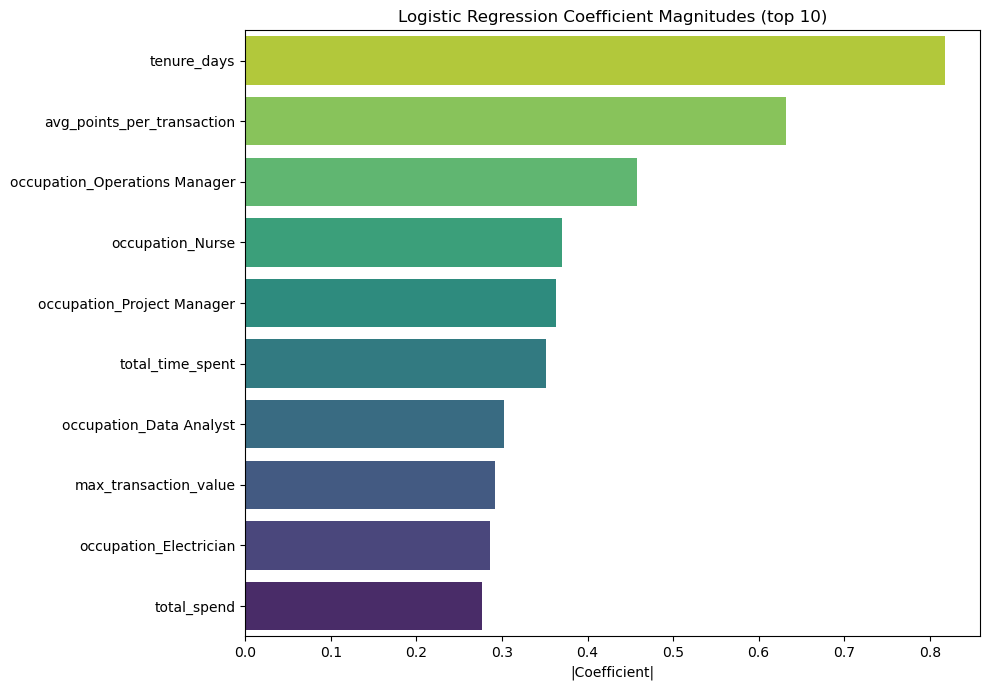

In [114]:
# Get feature names including one-hot encoded categories
feature_names = np.concatenate([
    np.array(numerical_cols),
    lr_grid.best_estimator_.named_steps['preprocessor']
           .named_transformers_['cat']
           .get_feature_names_out(categorical_cols)
])

# Get coefficients and take absolute values (since sign only indicates direction)
coefficients = np.abs(lr_grid.best_estimator_.named_steps['classifier'].coef_[0])

# Create importance DataFrame
lr_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': coefficients
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, max(6, len(lr_importance.head(20)) * 0.35)))
sns.barplot(x='importance', y='feature', 
           data=lr_importance.head(10).sort_values('importance', ascending=True),
           palette='viridis')
plt.gca().invert_yaxis()  # ensure most important shown at top
plt.title('Logistic Regression Coefficient Magnitudes (top 10)')
plt.xlabel('|Coefficient|')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [117]:
print(lr_importance.head(20))

                          feature  importance
17                    tenure_days    0.817774
15     avg_points_per_transaction    0.632162
42  occupation_Operations Manager    0.457654
41               occupation_Nurse    0.370660
44     occupation_Project Manager    0.363216
10               total_time_spent    0.351446
36        occupation_Data Analyst    0.302874
4           max_transaction_value    0.292359
37         occupation_Electrician    0.286632
2                     total_spend    0.276806
33                occupation_Chef    0.272336
5           min_transaction_value    0.268709
31       gender_Prefer not to say    0.262510
43     occupation_Product Manager    0.220210
28             tier_Very Frequent    0.217792
39      occupation_HR Coordinator    0.213942
19     avg_days_between_purchases    0.205021
14            total_points_earned    0.201225
47   occupation_Software Engineer    0.192747
49             occupation_Teacher    0.170383


## 5 Performance Evaluation & Model Selection

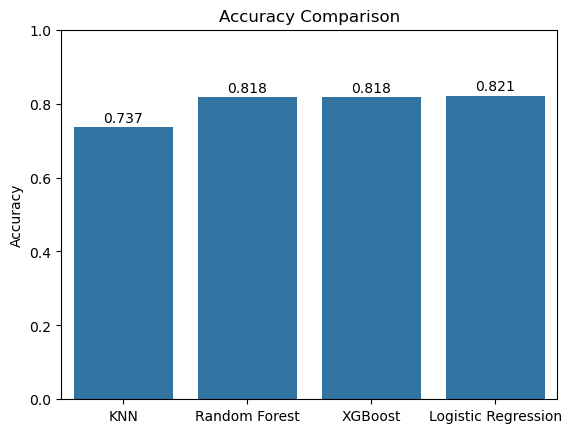

In [ ]:
sns.barplot(data=agg_results)
plt.title('Accuracy Comparison')
for i, (model, acc) in enumerate(agg_results.items()):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center', va='bottom')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.show()

In [94]:
agg_results

{'KNN': 0.737012987012987,
 'Random Forest': 0.8181818181818182,
 'XGBoost': 0.8181818181818182,
 'Logistic Regression': 0.8214285714285714}

In [95]:
print(f'Best Model: {max(agg_results, key=agg_results.get)}')

Best Model: Logistic Regression


# 6 Churn Prediction

In [124]:
# Create future prediction dataset
future_observation = '2025-10-29'
future_dataset = create_churn_dataset(orders_agg, future_observation, churn_window=60)

# print(future_dataset.head())




Creating dataset for: 2025-10-29
  Features from transactions up to: 2025-10-29
  Churn window: 2025-10-30 to 2025-12-28
  Total customers: 500
  Churned: 500 (100.0%)
  Retained: 0 (0.0%)
  Loyalty enrolled: {'Y': 308, 'N': 192}
  Tier distribution: {'Frequent': 179, 'Very Frequent': 126, 'Casual': 3}


In [125]:

# Prepare features (same as training)
X_future = future_dataset.drop(columns=['email', 'first_transaction_date', 'observation_date', 'churned'])

# Use best model to predict (Random Forest based on previous results)
future_predictions = rf_grid.predict(X_future)
future_prob = rf_grid.predict_proba(X_future)[:, 1]  # Probability of churning

# Create results DataFrame
churn_predictions = pd.DataFrame({
    'email': future_dataset['email'],
    'churn_probability': future_prob,
    'predicted_churn': future_predictions
})



d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [127]:
# Sort by churn probability to identify highest risk customers
high_risk = churn_predictions[churn_predictions['churn_probability'] > 0.5].sort_values(
    'churn_probability', ascending=False)

print(f"Total customers analyzed: {len(churn_predictions)}")
print(f"Predicted to churn: {len(high_risk)} ({len(high_risk)/len(churn_predictions):.1%})")
print("\nTop 10 highest risk customers:")
print(high_risk.head(10))



Total customers analyzed: 500
Predicted to churn: 16 (3.2%)

Top 10 highest risk customers:
                                email  churn_probability  predicted_churn
128     emily.gonzalez448@hotmail.com           0.759855                1
114    elijah.gonzalez127@outlook.com           0.605125                1
311  madison.macdonald156@outlook.com           0.603230                1
406           riley.chen260@gmail.com           0.595178                1
466    victoria.anderson348@gmail.com           0.589175                1
492       wyatt.tremblay450@yahoo.com           0.530973                1
84    charlotte.anderson449@yahoo.com           0.529088                1
294              luke.li135@yahoo.com           0.525335                1
43            aria.ivanov15@yahoo.com           0.524645                1
82          carter.white124@yahoo.com           0.519444                1


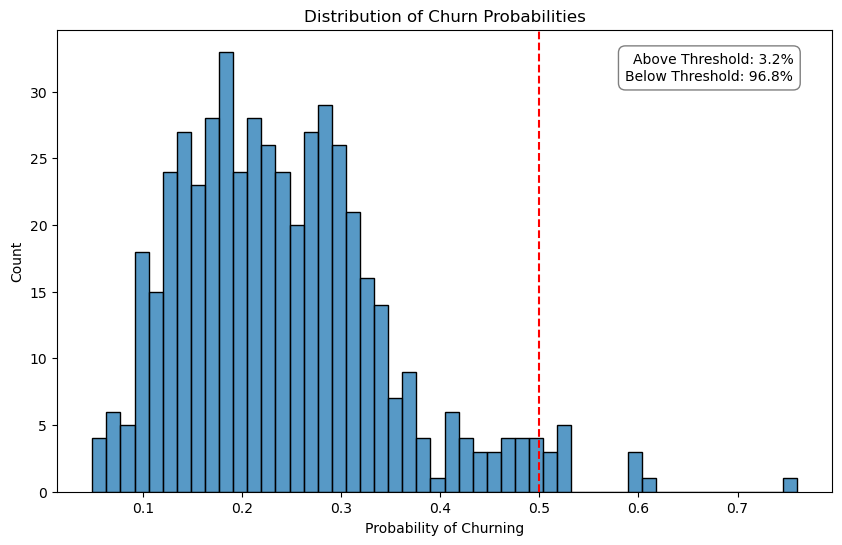

In [ ]:
# Visualize distribution of churn probabilities
plt.figure(figsize=(10, 6))
sns.histplot(data=churn_predictions, x='churn_probability', bins=50)
# add dash line to indicate threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Churn Threshold (0.5)')

above_threshold = (churn_predictions['churn_probability'] > 0.5).mean()
plt.text(0.95, 0.95, f'Above Threshold: {above_threshold:.1%}\nBelow Threshold: {1 - above_threshold:.1%}',
         horizontalalignment='right',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5)) 

plt.title('Distribution of Churn Probabilities')
plt.xlabel('Probability of Churning')
plt.ylabel('Count')
plt.show()





## 7. Simple Recommendation Strategy

In [ ]:
full_orders = pd.read_excel('full_orders.xlsx')

In [154]:

# high_risk_customers = high_risk['email'].tolist()
# high_risk_orders = full_orders[full_orders['email'].isin(high_risk_customers)]
# print(f"Total high-risk customer orders: {len(high_risk_orders)}")
# print(high_risk_orders.head(10))

# Link high_risk with full_oreders 
high_risk_orders = high_risk.merge(
    full_orders, on='email', how='inner'
)

print(f"Total high-risk customer orders: {len(high_risk_orders)}")
print(high_risk_orders.head(10))

Total high-risk customer orders: 517
                           email  churn_probability  predicted_churn  \
0  emily.gonzalez448@hotmail.com           0.759855                1   
1  emily.gonzalez448@hotmail.com           0.759855                1   
2  emily.gonzalez448@hotmail.com           0.759855                1   
3  emily.gonzalez448@hotmail.com           0.759855                1   
4  emily.gonzalez448@hotmail.com           0.759855                1   
5  emily.gonzalez448@hotmail.com           0.759855                1   
6  emily.gonzalez448@hotmail.com           0.759855                1   
7  emily.gonzalez448@hotmail.com           0.759855                1   
8  emily.gonzalez448@hotmail.com           0.759855                1   
9  emily.gonzalez448@hotmail.com           0.759855                1   

  transaction_id            transaction_date  time_spent_min  \
0        T003261       Sunday, July 27, 2025              88   
1        T003261       Sunday, July 27, 20

In [155]:
high_risk_orders.columns

Index(['email', 'churn_probability', 'predicted_churn', 'transaction_id',
       'transaction_date', 'time_spent_min', 'total_bill_amount', 'item_type',
       'item_id', 'item_name', 'category', 'unit_price_cad', 'quantity',
       'line_amount_cad'],
      dtype='object')

In [161]:
# Group by customer email and item_name, count frequency of orders
customer_favorites = high_risk_orders.groupby(['email', 'item_name'])['quantity'].sum().reset_index()

example_customer_email = "emily.gonzalez448@hotmail.com"
# focus on the example customer
example_customer_favorites = customer_favorites[customer_favorites['email'] == example_customer_email]
print(example_customer_favorites.sort_values('quantity', ascending=False))


                             email            item_name  quantity
102  emily.gonzalez448@hotmail.com               Coffee         3
109  emily.gonzalez448@hotmail.com       Skee-Ball Pack         3
112  emily.gonzalez448@hotmail.com         Veggie Pizza         2
103  emily.gonzalez448@hotmail.com         Energy Drink         2
97   emily.gonzalez448@hotmail.com    Arcade Credits 20         2
100  emily.gonzalez448@hotmail.com         Caesar Salad         2
96   emily.gonzalez448@hotmail.com   Air Hockey 30 mins         1
99   emily.gonzalez448@hotmail.com   BBQ Ribs Half Rack         1
98   emily.gonzalez448@hotmail.com    Arcade Credits 40         1
104  emily.gonzalez448@hotmail.com       House Wine 6oz         1
101  emily.gonzalez448@hotmail.com  Chocolate Lava Cake         1
105  emily.gonzalez448@hotmail.com         Mac & Cheese         1
106  emily.gonzalez448@hotmail.com            Margarita         1
108  emily.gonzalez448@hotmail.com              Poutine         1
107  emily